In [484]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np

# **IMG TO ARRS**

# TRAIN FORMING

In [485]:
X_train = []
y_train = []

for root, dirs, files in os.walk("train/hot_dog"):
    for file in files:
        img = Image.open(f'train/hot_dog/{file}')
        X_train.append(np.asarray(img))
        y_train.append(1)

for root, dirs, files in os.walk("train/not_hot_dog"):
    for file in files:
        img = Image.open(f'train/not_hot_dog/{file}')
        X_train.append(np.asarray(img))
        y_train.append(0)

In [486]:
X_train

[array([[[195,  97,  10],
         [196,  98,  11],
         [198,  98,  10],
         ...,
         [215, 120,   0],
         [212, 117,   0],
         [209, 114,   0]],
 
        [[194, 100,  13],
         [194, 100,  12],
         [194, 100,  12],
         ...,
         [216, 121,   1],
         [214, 119,   0],
         [214, 119,   0]],
 
        [[185, 101,  13],
         [186, 102,  12],
         [186, 102,  12],
         ...,
         [213, 118,   0],
         [212, 117,   0],
         [212, 117,   0]],
 
        ...,
 
        [[ 39,   3,   3],
         [ 39,   3,   3],
         [ 39,   3,   3],
         ...,
         [ 49,  36,  66],
         [ 50,  37,  67],
         [ 50,  37,  67]],
 
        [[ 39,   3,   3],
         [ 39,   3,   3],
         [ 39,   3,   3],
         ...,
         [ 49,  36,  64],
         [ 50,  37,  65],
         [ 50,  37,  65]],
 
        [[ 39,   3,   3],
         [ 39,   3,   3],
         [ 39,   3,   3],
         ...,
         [ 49,  36,  64],
  

In [487]:
len(y_train)

895

In [488]:
len(X_train)

895

# TEST FORMING

In [489]:
X_test = []
y_test = []

for root, dirs, files in os.walk("test/hot_dog"):
    for file in files:
        img = Image.open(f'test/hot_dog/{file}')
        X_test.append(np.asarray(img))
        y_test.append(1)

for root, dirs, files in os.walk("test/not_hot_dog"):
    for file in files:
        img = Image.open(f'test/not_hot_dog/{file}')
        X_test.append(np.asarray(img))
        y_test.append(0)

In [490]:
len(X_test)

100

In [491]:
len(y_test)

100

# PREPROCESSING

In [492]:
IM_SIZE = 224
def resize_rescale(img):
    return tf.image.resize(img, (IM_SIZE, IM_SIZE)) / 255.0

In [493]:
X_train = list(map(resize_rescale, X_train))

In [494]:
len(X_train)

895

In [495]:
X_test = list(map(resize_rescale, X_test))

# **SHUFFLING THE DATA**

In [496]:
from sklearn.utils import shuffle

In [497]:
X_train, y_train = shuffle(X_train, y_train)

In [498]:
X_test, y_test = shuffle(X_test, y_test)

# **VISUALIZATION**

In [499]:
import matplotlib.pyplot as plt
import seaborn as sns

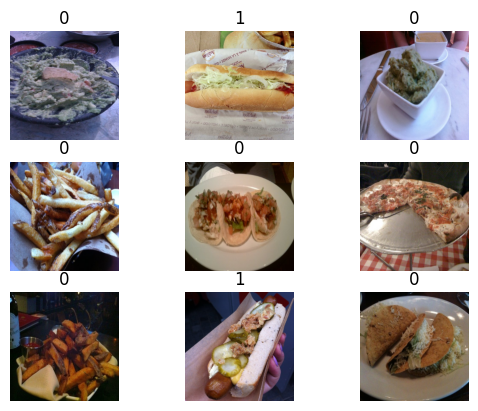

In [500]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.title(y_train[i])
    plt.imshow(X_train[i]);

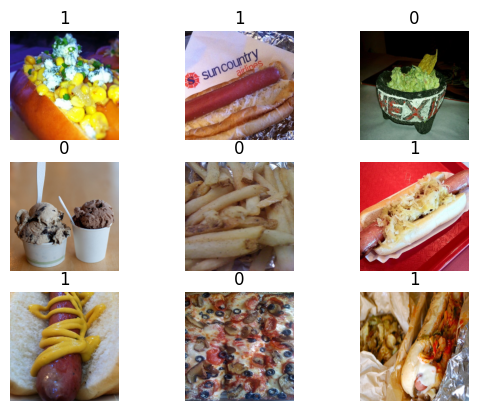

In [501]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.axis('off')
    plt.title(y_test[i])
    plt.imshow(X_test[i]);

# **MODEL BUILDING**

In [502]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [503]:
model = Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(2, activation='sigmoid')
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_45 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_46 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                     

In [504]:
model.compile(
    optimizer=Adam(),
    loss=SparseCategoricalCrossentropy(),
    metrics='accuracy'
)

In [505]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)

In [506]:
es_callback = EarlyStopping(
    patience=20,
    min_delta=0.01,
    restore_best_weights=True
)

In [507]:
X_train = np.array(X_train)

In [508]:
y_train = np.array(y_train)

In [509]:
X_train.shape

(895, 224, 224, 3)

In [510]:
hist = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    verbose=2,
    shuffle=True,
    # callbacks=[es_callback, scheduler_callback]
)

Epoch 1/15
23/23 - 6s - loss: 0.9220 - accuracy: 0.5475 - val_loss: 0.7057 - val_accuracy: 0.5251 - 6s/epoch - 249ms/step
Epoch 2/15
23/23 - 4s - loss: 0.4583 - accuracy: 0.7947 - val_loss: 0.6814 - val_accuracy: 0.5251 - 4s/epoch - 186ms/step
Epoch 3/15
23/23 - 4s - loss: 0.3014 - accuracy: 0.9120 - val_loss: 0.6953 - val_accuracy: 0.5140 - 4s/epoch - 186ms/step
Epoch 4/15
23/23 - 4s - loss: 0.1857 - accuracy: 0.9581 - val_loss: 0.6979 - val_accuracy: 0.5196 - 4s/epoch - 187ms/step
Epoch 5/15
23/23 - 4s - loss: 0.1068 - accuracy: 0.9804 - val_loss: 0.6987 - val_accuracy: 0.5028 - 4s/epoch - 186ms/step
Epoch 6/15
23/23 - 4s - loss: 0.0665 - accuracy: 0.9916 - val_loss: 0.7658 - val_accuracy: 0.5419 - 4s/epoch - 188ms/step
Epoch 7/15
23/23 - 4s - loss: 0.0793 - accuracy: 0.9777 - val_loss: 0.7159 - val_accuracy: 0.5698 - 4s/epoch - 187ms/step
Epoch 8/15
23/23 - 4s - loss: 0.0359 - accuracy: 0.9944 - val_loss: 0.7628 - val_accuracy: 0.5922 - 4s/epoch - 192ms/step
Epoch 9/15
23/23 - 5s - 

In [511]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [512]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 19ms/step - loss: 1.1064 - accuracy: 0.6700


[1.106385350227356, 0.6700000166893005]

In [513]:
pred = model.predict(X_test)

4/4 [==============================] - 0s 18ms/step


In [514]:
pred

array([[0.13709165, 0.7420866 ],
       [0.04003157, 0.99119496],
       [0.33652598, 0.6702432 ],
       [0.17217304, 0.4621239 ],
       [0.13033475, 0.45044437],
       [0.01426542, 0.9937221 ],
       [0.12518395, 0.964728  ],
       [0.61316854, 0.27992833],
       [0.6056805 , 0.24032113],
       [0.16768993, 0.00332286],
       [0.31405202, 0.43527254],
       [0.04393188, 0.96592736],
       [0.08151425, 0.5585717 ],
       [0.33086494, 0.0192165 ],
       [0.29998043, 0.5246886 ],
       [0.34345263, 0.12415452],
       [0.13550384, 0.90650135],
       [0.30574548, 0.14589919],
       [0.32546514, 0.11837199],
       [0.06647047, 0.9765305 ],
       [0.27807635, 0.88864464],
       [0.06707261, 0.9910423 ],
       [0.26938426, 0.9000959 ],
       [0.18962654, 0.7601858 ],
       [0.15621483, 0.811938  ],
       [0.11455362, 0.7624494 ],
       [0.16773044, 0.9413637 ],
       [0.47057897, 0.45801726],
       [0.21476676, 0.5558216 ],
       [0.14035496, 0.14382482],
       [0.

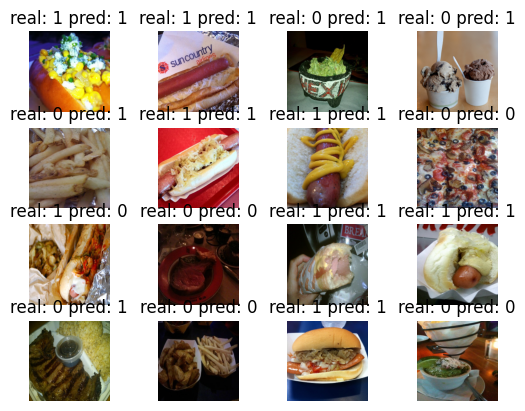

In [516]:
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.title(f'real: {y_test[i]} pred: {np.argmax(pred[i])}')
    plt.imshow(X_test[i]);

In [519]:
y_pred = []

for i in pred:
    y_pred.append(np.argmax(i))

y_pred[:5]

[1, 1, 1, 1, 1]

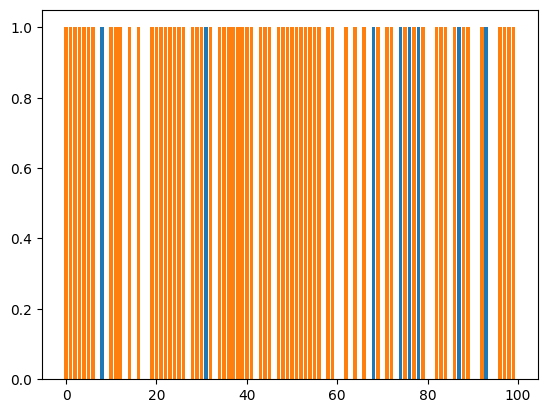

In [521]:
plt.bar(range(100), y_test);
plt.bar(range(100), y_pred);

# **THIS IS BETA ALPHA EARLY LEAKED DEV VERSION OF THIS PROJECT**
# But I'm happy as f. that it works!
# Later I'll add mobile app as promised and so on
# But Now it's Enough.

<img src='https://media.tenor.com/NK7_NwG8054AAAAM/shaq-floating.gif'>
<img src='https://media.tenor.com/NK7_NwG8054AAAAM/shaq-floating.gif'>
<img src='https://media.tenor.com/NK7_NwG8054AAAAM/shaq-floating.gif'>
<img src='https://media.tenor.com/NK7_NwG8054AAAAM/shaq-floating.gif'>
<img src='https://media.tenor.com/NK7_NwG8054AAAAM/shaq-floating.gif'>